# K Nearest Neighbors

### Andrew Larimer, Deepak Nagaraj, Daniel Olmstead, Michael Winton

#### W207-4-Summer 2018 Final Project

[Return to project overview](final_project_overview.ipynb)

In this notebook, we attempt to classify the PASSNYC data via K-Nearest Neighbors algorithm.  The idea is to use "K-nearest neighbors" classifier to "learn" schools that have high number of SHSAT registrations, and use that to predict on a test set.

***

### Reading data
Let us do some initial imports and set up the data.

In [1]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

from sklearn.decomposition import PCA

import util

# set default options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

k_folds = 5
%matplotlib inline

In [2]:
# Get train-test split
train_data, test_data, train_labels, test_labels = util.read_data()

print("Train data shape: %s" % str(train_data.shape))
print("Test data shape: %s" % str(test_data.shape))
train_data.head()

Train: 371 observations (positive class fraction: 0.232)
Test : 93 observations (positive class fraction: 0.226)
Train data shape: (371, 75)
Test data shape: (93, 75)


,dbn,grade_7_enrollment,num_shsat_test_takers,offers_per_student,pct_test_takers,school_name,district,zip,community_school,economic_need_index,school_income_estimate,percent_ell,percent_asian,percent_black,percent_hispanic,percent_black__hispanic,percent_white,student_attendance_rate,percent_of_students_chronically_absent,rigorous_instruction_percent,rigorous_instruction_rating,collaborative_teachers_percent,collaborative_teachers_rating,supportive_environment_percent,supportive_environment_rating,effective_school_leadership_percent,effective_school_leadership_rating,strong_family_community_ties_percent,strong_family_community_ties_rating,trust_percent,trust_rating,student_achievement_rating,average_ela_proficiency,average_math_proficiency,grade_7_ela_all_students_tested,grade_7_ela_4s_all_students,grade_7_ela_4s_american_indian_or_alaska_native,grade_7_ela_4s_black_or_african_american,grade_7_ela_4s_hispanic_or_latino,grade_7_ela_4s_asian_or_pacific_islander,grade_7_ela_4s_white,grade_7_ela_4s_multiracial,grade_7_ela_4s_limited_english_proficient,grade_7_ela_4s_economically_disadvantaged,grade_7_math_all_students_tested,grade_7_math_4s_all_students,grade_7_math_4s_american_indian_or_alaska_native,grade_7_math_4s_black_or_african_american,grade_7_math_4s_hispanic_or_latino,grade_7_math_4s_asian_or_pacific_islander,grade_7_math_4s_white,grade_7_math_4s_multiracial,grade_7_math_4s_limited_english_proficient,grade_7_math_4s_economically_disadvantaged,sie_provided,in_bronx,in_brooklyn,in_manhattan,in_queens,in_staten,number_of_students_english,number_of_students_math,number_of_students_science,number_of_students_social_studies,number_of_classes_english,number_of_classes_math,number_of_classes_science,number_of_classes_social_studies,average_class_size_english,average_class_size_math,average_class_size_science,average_class_size_social_studies,school_pupil_teacher_ratio,gifted,selective
421,22K014,168,41,0,19,J.H.S. 014 SHELL BANK,22,11235,0,0.708,NaN,18,11,48,17,64,24,92.0,29.0,86.0,3.0,91.0,3.0,80.0,3.0,86.0,3.0,71.0,2.0,92.0,3.0,3.0,2.32,2.41,165,8,0,3,1,0,2,0,0,7,178,14,0,2,2,0,6,0,1,14,0,0,1,0,0,0,767.0,606.0,765.0,622.0,37.0,29.0,36.0,28.0,20.729730,20.896552,21.2500,22.214286,12.5,0,0
344,32K554,61,22,0,17,ALL CITY LEADERSHIP SECONDARY SCHOOL,32,11237,0,0.667,NaN,2,6,11,77,89,5,97.0,8.0,92.0,4.0,99.0,4.0,96.0,4.0,92.0,4.0,83.0,3.0,98.0,4.0,3.0,3.28,3.47,60,22,0,2,18,0,0,0,0,20,60,19,0,2,15,0,0,0,0,17,0,0,1,0,0,0,330.0,180.0,180.0,180.0,13.0,6.0,6.0,6.0,25.384615,30.000000,30.0000,30.000000,23.9,0,0
279,19K654,106,15,0,16,VAN SICLEN COMMUNITY MIDDLE SCHOOL,19,11207,0,0.780,NaN,14,2,68,28,96,2,90.0,33.0,86.0,3.0,96.0,3.0,83.0,3.0,93.0,4.0,80.0,3.0,95.0,4.0,2.0,1.96,1.95,110,0,0,0,0,0,0,0,0,0,113,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,312.0,327.0,327.0,297.0,14.0,14.0,12.0,12.0,22.285714,23.357143,27.2500,24.750000,16.7,0,0
244,17K394,49,12,0,21,M.S. K394,17,11213,0,0.797,32470.47,4,6,77,15,92,1,92.0,24.0,89.0,3.0,86.0,3.0,83.0,2.0,80.0,3.0,82.0,2.0,85.0,2.0,2.0,2.35,2.21,57,1,0,1,0,0,0,0,0,0,57,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,284.0,308.0,154.0,154.0,13.0,14.0,7.0,7.0,21.846154,22.000000,22.0000,22.000000,14.0,0,0
379,08X562,120,29,0,30,BLUEPRINT MIDDLE SCHOOL,8,10472,0,0.796,NaN,15,23,18,56,74,1,92.0,29.0,93.0,3.0,95.0,3.0,80.0,2.0,93.0,4.0,79.0,3.0,91.0,3.0,2.0,2.23,2.17,102,2,0,0,0,1,0,0,0,1,101,4,0,0,0,4,0,0,0,4,0,1,0,0,0,0,49.0,331.0,383.0,NaN,2.0,14.0,16.0,NaN,24.500000,23.642857,23.9375,NaN,13.3,0,0


#### Feature selection

We will now select some features from the above dataset.

We will ignore some categorical variables and variables that are highly correlated with outcome variable.

In [3]:
drop_cols = [
    # non-numeric
    'dbn',
    # correlated with outcome variable
    'num_shsat_test_takers',
    'offers_per_student',
    'pct_test_takers',
    # demographic or correlated with demographics
    'school_name',
    'zip',
    'district',
    # too many nulls
    'school_income_estimate',
]
y = train_labels
perf_train_data = train_data.drop(drop_cols, axis=1)
perf_train_data_nonull = perf_train_data.fillna(perf_train_data.mean())
perf_test_data = test_data.drop(drop_cols, axis=1)
perf_test_data_nonull = perf_test_data.fillna(perf_test_data.mean())

***

## K-Nearest Neighbors Classification

We will now run KNN on the dataset.  We will run it in three ways:

1. Run with all features except for the dropped ones above
2. Run with a few features, based on a feature selection algorithm
3. Run PCA, then run with all features except for the dropped ones above

### 1/3. KNN with most features
We will now run KNN prediction on the dataset.  We will use grid search to get the best value for the hyper-parameter $k$.

#### Searching for best $k$
Let us experiment with various values of $k$ to see which gives the best results.

In [4]:
pipeline = make_pipeline(StandardScaler(), 
                         KNeighborsClassifier())
n_neighbors = list(range(1, 15))
estimator = GridSearchCV(pipeline,
                        dict(kneighborsclassifier__n_neighbors=n_neighbors),
                        cv=k_folds, n_jobs=-1, scoring='f1')
estimator.fit(perf_train_data_nonull, y)

best_k_all_features = estimator.best_params_['kneighborsclassifier__n_neighbors']
print("Best no. of neighbors: %d" % best_k_all_features)

Best no. of neighbors: 3


The best value for number of neighbors is $k=3$.  Let us get the scores for this value of $k$.

In [5]:
scaler = StandardScaler().fit(perf_train_data_nonull)
rescaledX = scaler.transform(perf_train_data_nonull)
# Do k-fold cross-validation, collecting both "test" accuracy and F1 
clf = KNeighborsClassifier(n_neighbors=best_k_all_features)
cv_scores = cross_validate(clf, rescaledX, y, cv=k_folds, scoring=['accuracy', 'f1'])
util.print_cv_results(cv_scores)

With 5-fold cross-validation, accuracy is: 0.849 (95% CI from 0.721 to 0.976).
The F1 score is: 0.637 (95% CI from 0.328 to 0.946).


We get accuracy of 85% and F1 of 0.64.

*** 

### 2/3. KNN with select features

We will now attempt to do some feature selection, followed by running KNN.

In [6]:
pipeline = make_pipeline(StandardScaler(), 
                         SelectFromModel(ExtraTreesClassifier(random_state=207)))
pipeline.fit_transform(perf_train_data_nonull, y)
selected_features = pipeline.steps[1][1].get_support()
selected_cols = perf_train_data_nonull.columns[selected_features].values.tolist()
print("Selected feature columns: %s" % selected_cols)

Selected feature columns: ['percent_ell', 'percent_hispanic', 'percent_black__hispanic', 'student_attendance_rate', 'percent_of_students_chronically_absent', 'effective_school_leadership_rating', 'student_achievement_rating', 'average_ela_proficiency', 'average_math_proficiency', 'grade_7_ela_4s_all_students', 'grade_7_ela_4s_economically_disadvantaged', 'grade_7_math_4s_all_students', 'grade_7_math_4s_economically_disadvantaged', 'number_of_students_science', 'average_class_size_english', 'average_class_size_math', 'school_pupil_teacher_ratio']


#### Searching for best $k$

Let us also find the best number of neighbors for this subset of features.

In [7]:
pipeline = make_pipeline(StandardScaler(), 
                         KNeighborsClassifier())
n_neighbors = list(range(1, 15))
estimator = GridSearchCV(pipeline,
                        dict(kneighborsclassifier__n_neighbors=n_neighbors),
                        cv=k_folds, n_jobs=-1, scoring='f1')

perf_train_data_nonull_sel_cols = selected_cols
perf_train_data_nonull_sel = perf_train_data_nonull[perf_train_data_nonull_sel_cols]
estimator.fit(perf_train_data_nonull_sel, y)

best_k_some_features = estimator.best_params_['kneighborsclassifier__n_neighbors']
print("Best no. of neighbors: %d" % best_k_some_features)

Best no. of neighbors: 11


We will use this to run cross-validation on the model.

In [8]:
scaler = StandardScaler().fit(perf_train_data_nonull_sel)
rescaledX_sel = scaler.transform(perf_train_data_nonull_sel)
clf = KNeighborsClassifier(n_neighbors=best_k_some_features)

# Do k-fold cross-validation, collecting both "test" accuracy and F1 
cv_scores = cross_validate(clf, rescaledX_sel, y, cv=k_folds, scoring=['accuracy','f1'])
util.print_cv_results(cv_scores)

With 5-fold cross-validation, accuracy is: 0.841 (95% CI from 0.756 to 0.926).
The F1 score is: 0.586 (95% CI from 0.376 to 0.795).


F1 score falls a little to 0.59.

***

### 3/3. KNN with reduced dimensions

We will next attempt to reduce dimensions via PCA, followed by KNN.

First, we will attempt to find the best number of components.

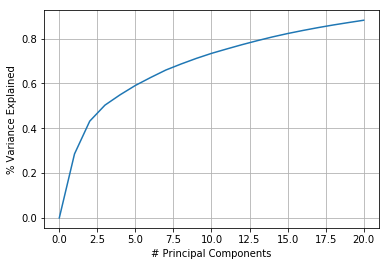

67

In [9]:
# generate plot of variance explained vs # principale components
util.get_num_pcas(perf_train_data_nonull, var_explained=0.9)

We can see that the first 3 components already explain about 40% of variance.  The slope of the graph goes down after this.

#### Searching for best $k$

Let us run GridSearch on both PCA components and K, to see if we can get a better model.

In [10]:
pipeline = make_pipeline(StandardScaler(), 
                         PCA(random_state=207),
                         KNeighborsClassifier())

n_components = list(range(1, 12))
n_neighbors = list(range(1, 15))
estimator = GridSearchCV(pipeline,
                        dict(pca__n_components=n_components,
                             kneighborsclassifier__n_neighbors=n_neighbors),
                             cv=k_folds, scoring='f1')
estimator.fit(perf_train_data_nonull, y)

best_pca_components = estimator.best_params_['pca__n_components']
best_k_with_pca = estimator.best_params_['kneighborsclassifier__n_neighbors']
print("Best no. of PCA components: %d, neighbors: %d" % 
      (best_pca_components,
       best_k_with_pca))

Best no. of PCA components: 8, neighbors: 7


We find that PCA with 8 components, followed by KNN with 7 neighbors is the best combination.

In [11]:
# Do k-fold cross-validation, collecting both "test" accuracy and F1 
pipeline = make_pipeline(StandardScaler(), 
                         PCA(random_state=207, n_components=best_pca_components),
                         KNeighborsClassifier(n_neighbors=best_k_with_pca))

cv_scores = cross_validate(pipeline, perf_train_data_nonull, train_labels, cv=k_folds, scoring=['accuracy', 'f1'])
util.print_cv_results(cv_scores)

With 5-fold cross-validation, accuracy is: 0.841 (95% CI from 0.714 to 0.967).
The F1 score is: 0.630 (95% CI from 0.357 to 0.903).


With this combination, we get accuracy of 84% and F1 score of 0.63.

Let us summarize our three runs of KNN so far.

***

### Summary

Model | CV Accuracy | (95% CI) | CV F1 | (95% CI)
:---|:---:|:---:|:---:|:---:
K-Nearest Neighbors (Most features) | 0.849 | (0.721, 0.976) | 0.637 | (0.328, 0.946)
K-Nearest Neighbors (Top n Features) | 0.841 | (0.756, 0.926) | 0.586 | (0.376, 0.795)
K-Nearest Neighbors (PCA, most features) | 0.841 | (0.714, 0.967) | 0.630 | (0.357, 0.903)

The first model gives the best F1.  We will now use it to run on the test set and also for the final table.

In [12]:
pipeline = make_pipeline(StandardScaler(), 
                         KNeighborsClassifier(n_neighbors=best_k_all_features))
pipeline.fit(perf_train_data_nonull, train_labels)
predicted_labels = pipeline.predict(perf_test_data_nonull)
knn_score_accuracy = metrics.accuracy_score(test_labels, predicted_labels)
knn_score_f1 = metrics.f1_score(test_labels, predicted_labels)

print("On the test set, the model has an accuracy of {:.2f}% and an F1 score of {:.2f}."
     .format(knn_score_accuracy*100, knn_score_f1))

On the test set, the model has an accuracy of 87.10% and an F1 score of 0.73.


On test set, we get 87% accuracy, and good F1 score at 0.73.

We will use the last model run above (PCA, most features) to generate the school list.

***

## Recommendations for PASSNYC

Lastly, according to the methodology described in our [overview notebook](final_project_overview.ipynb), we will make our recommendations to PASSNYC based on an analysis of schools that the models show to have the highest opportunity to engage with Black and Hispanic students, in order to increase SHSAT registration in this population. We consider these to be the schools that are most likely to benefit from PASSNYC's intervention and engagement.

In [13]:
pipeline = make_pipeline(StandardScaler(),
                         KNeighborsClassifier(n_neighbors=best_k_all_features))

fp_df = util.run_model_get_ordered_predictions(pipeline, train_data, test_data,
                                               perf_train_data_nonull, perf_test_data_nonull,
                                               train_labels, test_labels)

Now that we have the false positives, we will obtain a ranking of the schools that we can provide to PASSNYC.

In [14]:
df_passnyc = util.create_passnyc_list(fp_df, train_data, test_data,
                                 train_labels, test_labels)
# Write to CSV
df_passnyc.to_csv('results/results.knn.csv')

df_passnyc

,rank,1s,dbn,school_name,economic_need_index,grade_7_enrollment,num_shsat_test_takers,pct_test_takers,percent_black__hispanic,minority_delta,score
56,1,9.0,27Q210,J.H.S. 210 ELIZABETH BLACKWELL,0.602,643,169,26,67,106,95.4
108,2,4.0,30Q145,I.S. 145 JOSEPH PULITZER,0.682,582,137,23,90,144,57.6
45,3,10.0,30Q230,I.S. 230,0.601,439,157,36,57,38,38.0
40,4,10.0,20K220,J.H.S. 220 JOHN J. PERSHING,0.828,473,181,34,45,27,27.0
457,5,1.0,24Q061,I.S. 061 LEONARDO DA VINCI,0.748,752,93,13,92,267,26.7
98,6,10.0,11X181,I.S. 181 PABLO CASALS,0.534,295,124,42,89,24,24.0
461,7,3.0,29Q238,I.S. 238 - SUSAN B. ANTHONY ACADEMY,0.609,471,123,23,67,79,23.7
35,8,10.0,21K281,I.S. 281 JOSEPH B CAVALLARO,0.631,492,171,42,29,23,23.0
22,9,10.0,25Q194,J.H.S. 194 WILLIAM CARR,0.340,416,147,37,31,20,20.0
432,10,10.0,22K207,P.S. 207 ELIZABETH G. LEARY,0.315,162,43,30,49,19,19.0
